# Importing Libraries

In [1]:
import os
import cv2
import glob as gb
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px
import requests
from io import BytesIO
import zipfile
import os
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Tensorflow
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# metrics
from sklearn.metrics import classification_report, confusion_matrix

2024-03-10 15:11:20.144787: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 15:11:20.144905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 15:11:20.279453: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Reading and formatting data

In [2]:
# Your label mapping and file paths
label_mapping = {
    'buildings': 0,
    'forest': 1,
    'glacier': 2,
    'mountain': 3,
    'sea': 4,
    'street': 5
}

train_file = r"/kaggle/input/intel-image-classification/seg_train/seg_train"
test_file = r"/kaggle/input/intel-image-classification/seg_train/seg_train"

# Load training data
X_train = []
y_train = []

# Define common size for resizing
common_size = (224, 224)

for folder in os.listdir(train_file):
    folder_path = os.path.join(train_file, folder)
    files = gb.glob(pathname=os.path.join(folder_path, "*.jpg"))
    for file in files:
        image = Image.open(file)
        image = image.resize(common_size)  # Resize image to a common size
        X_train.append(np.array(image))
        y_train.append(label_mapping.get(folder, -1))

X_train = np.array(X_train)
y_train = np.array(y_train)

# Load testing data
X_test = []
y_test = []
for folder in os.listdir(test_file):
    folder_path = os.path.join(test_file, folder)
    files = gb.glob(pathname=os.path.join(folder_path, "*.jpg"))
    for file in files:
        image = Image.open(file)
        image = image.resize(common_size)  # Resize image to a common size
        X_test.append(np.array(image))
        y_test.append(label_mapping.get(folder, -1))

X_test = np.array(X_test)
y_test = np.array(y_test)

# Check the number of items in each set and their shapes
print("Number of items in the training set:", len(X_train))
print("Number of items in the testing set:", len(X_test))

Number of items in the training set: 14034
Number of items in the testing set: 14034


In [3]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (14034, 224, 224, 3)
Shape of y_train: (14034,)
Shape of X_test: (14034, 224, 224, 3)
Shape of y_test: (14034,)


# Sample data

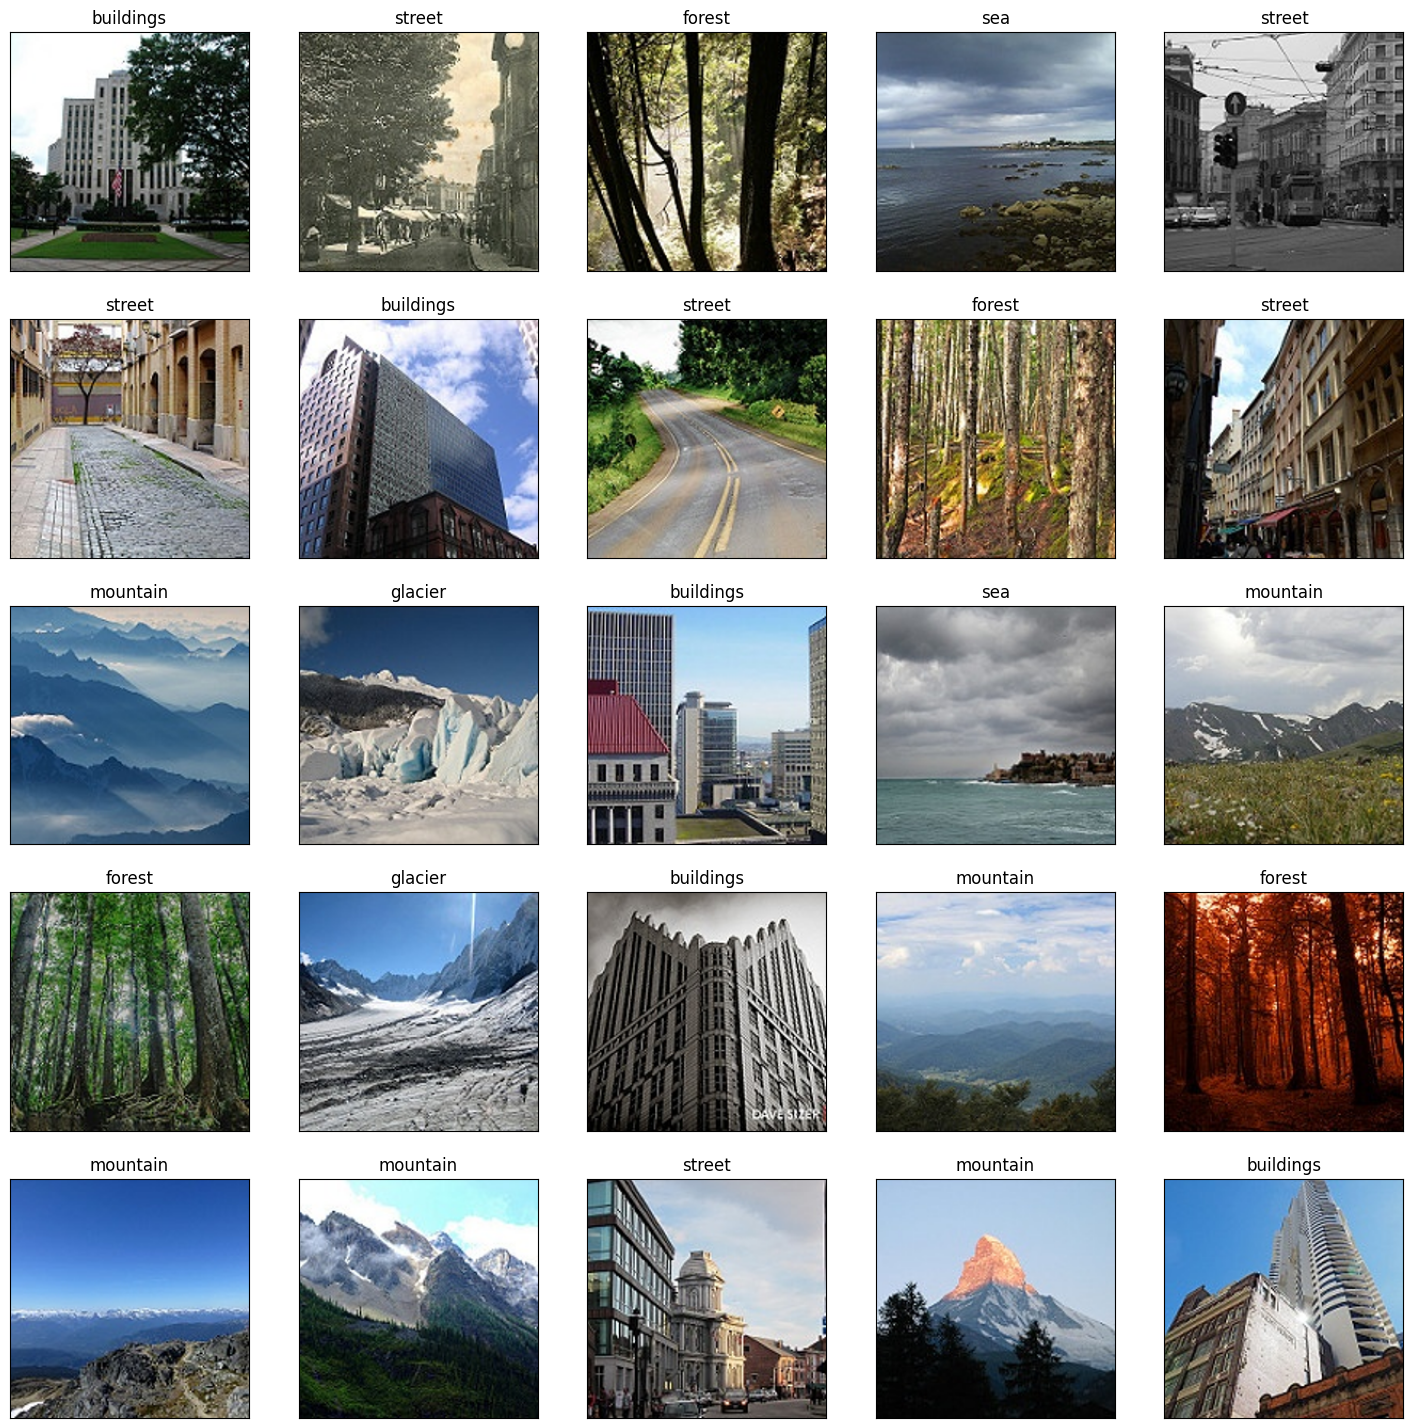

In [4]:
plt.figure(figsize=(18, 18))

random_list = random.sample(range(13001), 25)
i = 0
for j in random_list:
    plt.subplot(5, 5, i+1)
    plt.imshow(X_train[j])
    label_code = y_train[j]
    label_name = [key for key, value in label_mapping.items() if value == label_code][0]
    plt.title(label_name)
    plt.xticks([])
    plt.yticks([])
    i+=1

plt.show()

In [5]:
X_train[0].shape

(224, 224, 3)

# Preprocessing and Modeling

In [6]:

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32 , kernel_size=(5,5),
                           strides=(1,1), padding="same", activation="relu",
                           input_shape=X_train[0].shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=64 , kernel_size=(5,5),activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 108, 108, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,942,598 (91.33 MB)

 Trainable params: 23,942,534 (91.33 MB)

 Non-trainable params: 64 (256.00 B)

Ploting the Model

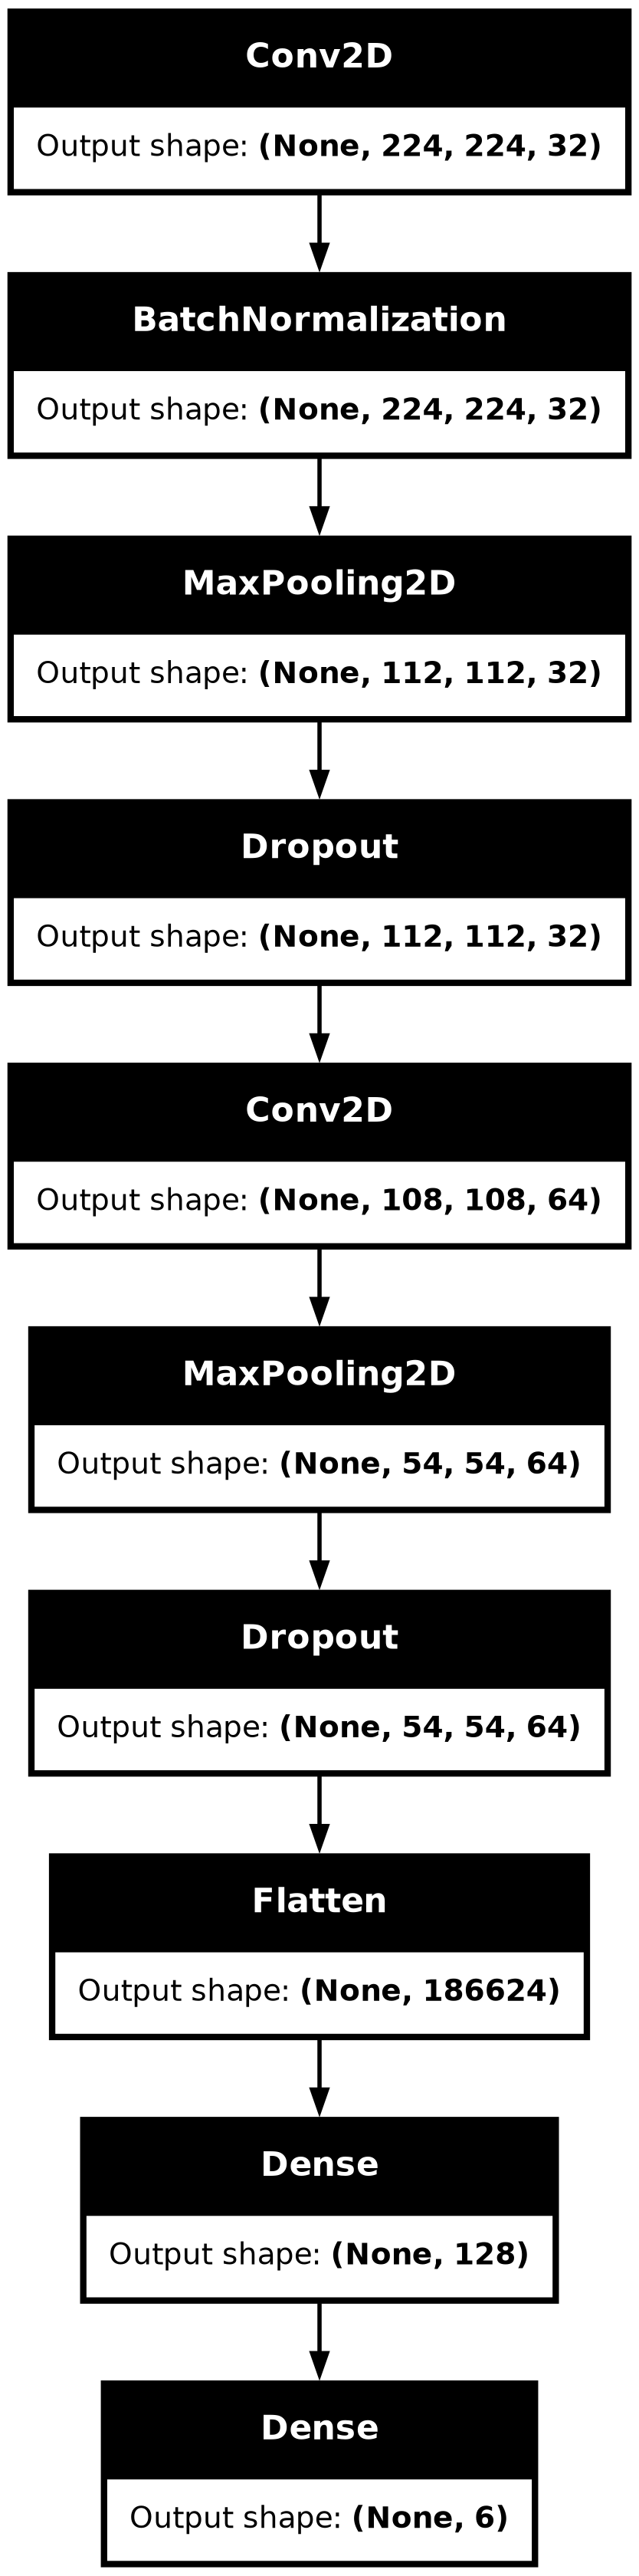

In [7]:
tf.keras.utils.plot_model(model, '/kaggle/working/model.png', show_shapes=True)

In [8]:
model.compile(optimizer="adam" , loss='sparse_categorical_crossentropy',metrics=['accuracy'])
early = EarlyStopping(patience=5, restore_best_weights=True)
# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[early])

Epoch 1/20
  5/439 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.1887 - loss: 110.0244

I0000 00:00:1710083642.819344      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


439/439 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - accuracy: 0.4673 - loss: 11.9354 - val_accuracy: 0.6988 - val_loss: 0.8326
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.7558 - loss: 0.6839 - val_accuracy: 0.7659 - val_loss: 0.6326
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.8378 - loss: 0.4671 - val_accuracy: 0.8686 - val_loss: 0.4078
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.8879 - loss: 0.3175 - val_accuracy: 0.9142 - val_loss: 0.2698
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.9201 - loss: 0.2399 - val_accuracy: 0.8570 - val_loss: 0.4759
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.9384 - loss: 0.1784 - val_accuracy: 0.8987 - val_loss: 0.2850
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.9507 - loss: 0.1541 - val_accuracy: 0.8989 - val_loss: 0.2926
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.9589 - loss: 0.1364 - val_accura

# Model Evaluation

In [9]:
loss , acc = model.evaluate(X_train , y_train)
print("Accuracy : ",acc)
print("loss : " , loss)

439/439 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9940 - loss: 0.0232
Accuracy :  0.9938720464706421
loss :  0.02083345502614975


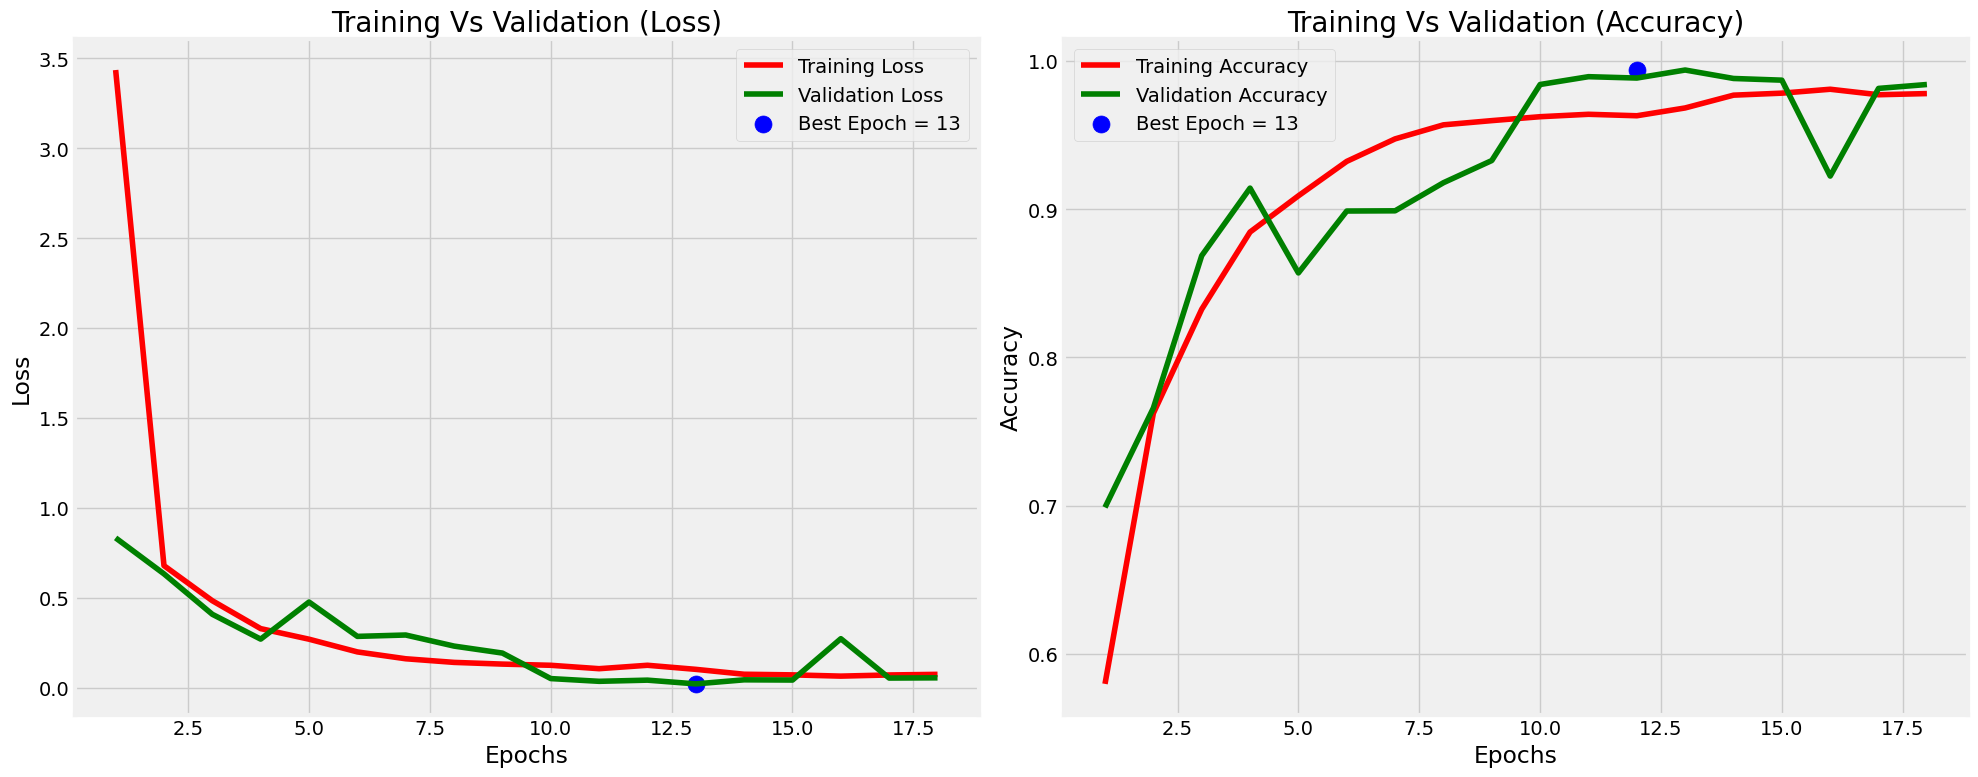

In [10]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)
val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_loss = f'Best Epoch = {str(index_acc +1)}'

#Training Accuracy
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue' , label= loss_label)
plt.title('Training Vs Validation (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
plt.plot(epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc , val_highest , s= 150 , c= 'blue' , label = acc_loss)
plt.title('Training Vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show();

# Model Prediction

In [11]:
file_pred = r"/kaggle/input/intel-image-classification/seg_pred"

for folder in os.listdir(file_pred):
    folder_files = os.path.join(file_pred, folder)
    files = gb.glob(pathname=os.path.join(folder_files, "*.jpg"))
    print(f"For files in folder {folder}, the number of items is {len(files)}")

For files in folder seg_pred, the number of items is 7301


In [12]:
def get_key_from_value(dictionary, value):
    return next((key for key, val in dictionary.items() if val == value), None)


439/439 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
[3 3 3 ... 2 2 2]


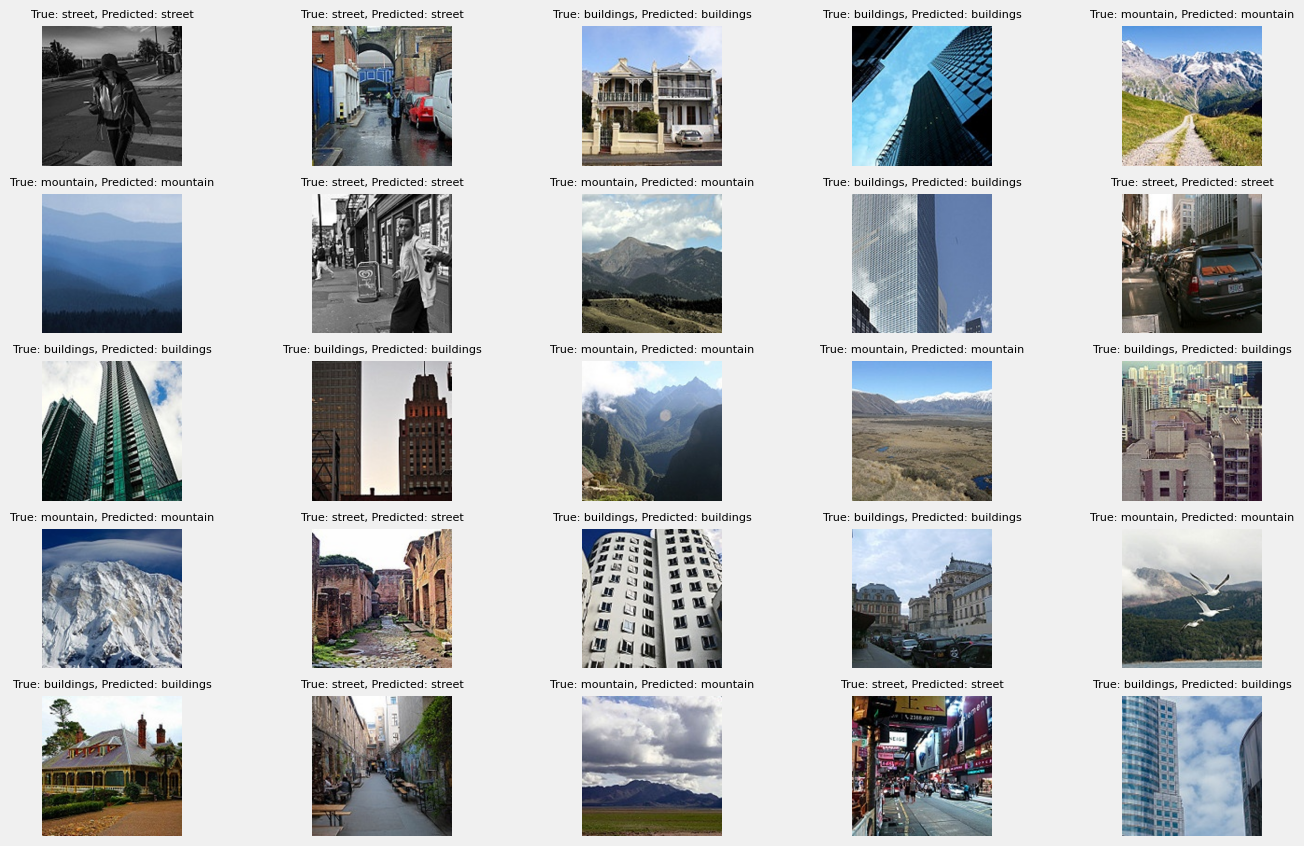

In [13]:
predictions = model.predict(X_test)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

print(predicted_classes)

# Visualize the predictions
plt.figure(figsize=(15, 10))
random_list2 = random.sample(range(7001), 25)
j=0
for i in random_list2: 
    plt.subplot(5, 5, j + 1)
    plt.imshow(X_test[i], cmap='gray')
    label1 = get_key_from_value(label_mapping, y_test[i])
    label_code = y_test[i]
    label_name = [key for key, value in label_mapping.items() if value == label_code][0]
    
    plt.title(f"True: {label1}, Predicted: {label_name}", fontsize=8)
    plt.axis('off')
    j+=1
plt.show()

In [14]:
model.save("model.h5") # saving the model

# Confusion matrix and Classification report

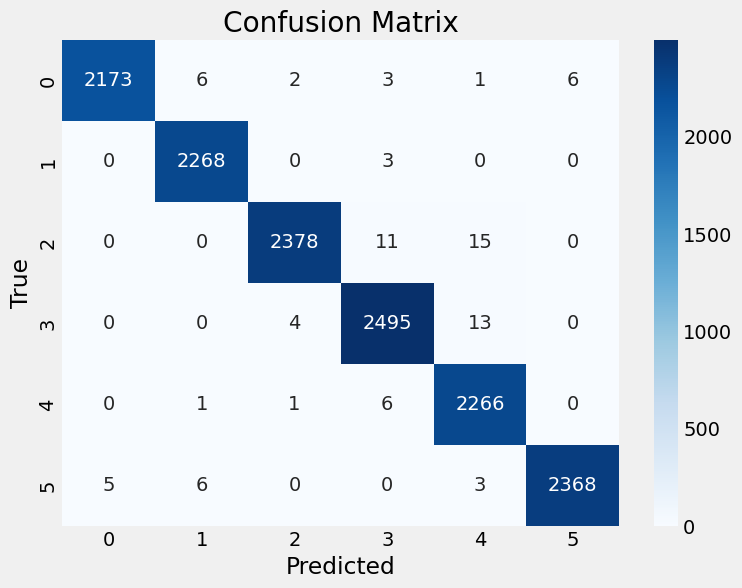


Classification Report:
              precision    recall  f1-score   support

   buildings       1.00      0.99      0.99      2191
      forest       0.99      1.00      1.00      2271
     glacier       1.00      0.99      0.99      2404
    mountain       0.99      0.99      0.99      2512
         sea       0.99      1.00      0.99      2274
      street       1.00      0.99      1.00      2382

    accuracy                           0.99     14034
   macro avg       0.99      0.99      0.99     14034
weighted avg       0.99      0.99      0.99     14034



In [15]:
# Create confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Extract class labels in the correct order
class_labels = list(label_mapping.keys())

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, predicted_classes, target_names=class_labels))

# Thank you!